## **Импорт библиотек**

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch torchvision torchaudio
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install scikit-learn
!pip install transformers
!pip install datasets
!pip install 'accelerate>=0.26.0'
!pip install nltk
!pip install pymorphy3
!pip install ollama

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import json

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.utils import resample
from datasets import Dataset

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pymorphy3

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)

import torch

print("MPS available:", torch.backends.mps.is_available())
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

os.environ["PATH"] += ":/usr/local/bin"
import ollama
!ollama pull mistral:7b-instruct-v0.2-q4_0

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimapahomov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


MPS available: True
Using device: mps
zsh:1: command not found: ollama


## **EDA**

In [5]:
df = pd.read_json('train_hackathon_dataset.json')

In [6]:
# Формат данных
df.head(10)

,idx,text,label
0,10026,[PERSON]\n\nУважаемый [PERSON]!\n\n[ORGANIZATI...,Блок директора по проектированию
1,1005,[ORGANIZATION] инжиниринг общество с ограничен...,Блок деректора по газу
2,1010,[ORGANIZATION] ИНВЕСТ Общество с ограниченной ...,Блок заместителя генерального директора по без...
3,1013,[ORGANIZATION] филиал [OBJECT] имени [PERSON] ...,Блок технического директора
4,10186,[ORGANIZATION] ЗАМЕСТИТЕЛЬ ГЕНЕРАЛЬНОГО ДИРЕКТ...,Блок директора по проектированию
5,10236,"[ORGANIZATION] улица [LOCATION], дом [NUMBER],...",Блок директора по проектированию
6,10282,[ORGANIZATION] [LOCATION] [CONTACT] [DATE_TIME...,Блок директора по проектированию
7,10543,"[ORGANIZATION] Почтовый адрес: [LOCATION], Ори...",Блок директора по проектированию
8,1078,73 года с 1951 года ПРОЕКТНО-ИЗЫСКАТЕЛЬСКИЙ ИН...,Блок технического директора
9,1088,[ORGANIZATION] [CONTACT] [ORGANIZATION] [LOCAT...,Блок заместителя генерального директора по зак...


In [7]:
# Распределение классов
df['label'].value_counts()

label
Блок технического директора                                                     199
Блок директора по мощностям                                                     194
Блок директора по строительству                                                 134
Управление по проектным работам                                                 109
Блок заместителя генерального директора по безопасности                         100
Генеральный директор                                                             82
Проект "Нефтяные краюшки"                                                        63
Блок деректора по газу                                                           58
Блок заместителя генерального директора по закупкам                              54
Блок заместителя генерального директора по организационным вопросам              46
Проект сервиса скважин                                                           38
Блок директора по проектированию                                      

/var/folders/sc/dg9s73x558g7t30467ld1ydw0000gn/T/ipykernel_20145/439442359.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


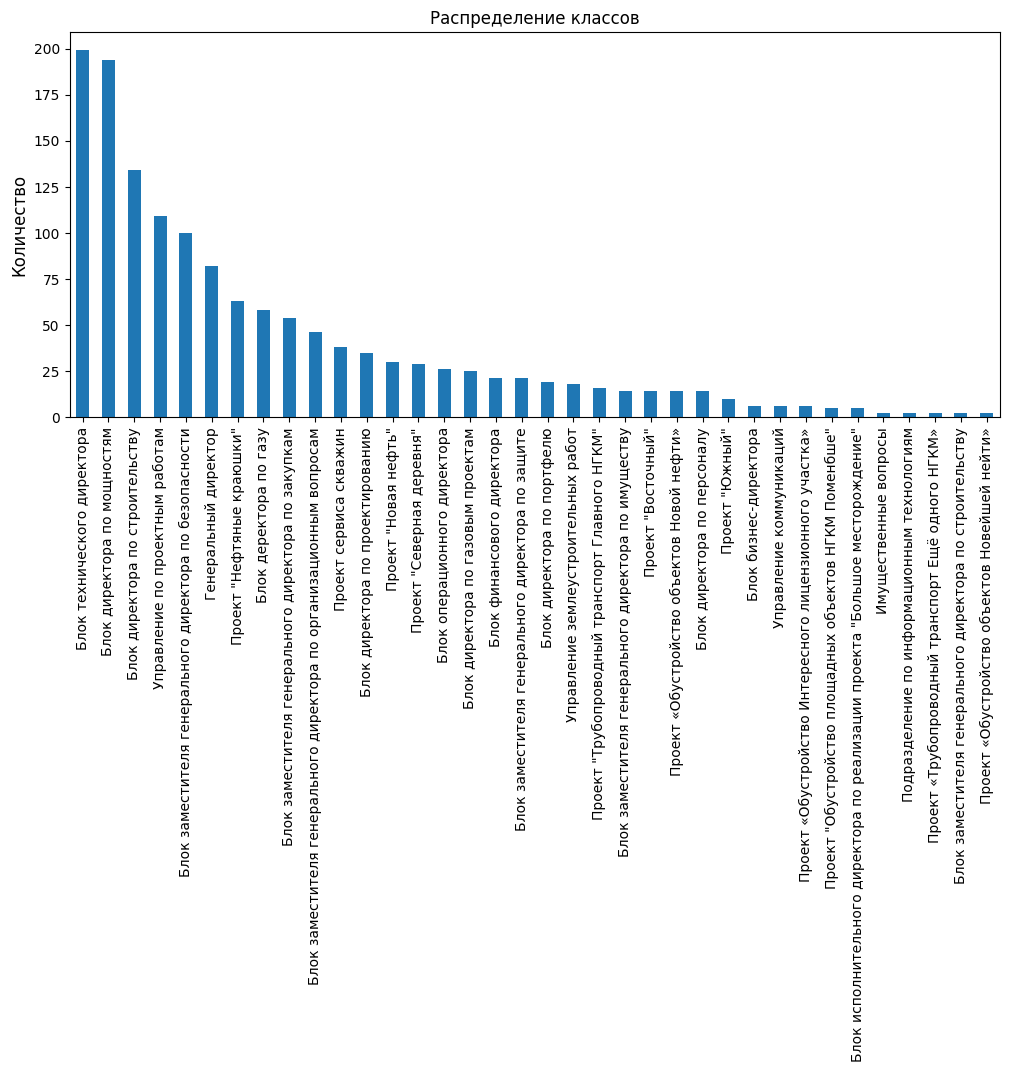

In [8]:
# Визуализация распределения классов
fig, axes = plt.subplots(figsize=(12, 5))

df['label'].value_counts().plot(kind='bar', ax=axes)
axes.set_title('Распределение классов')
axes.set_xlabel('')
axes.set_ylabel('Количество', fontsize=12)

plt.tight_layout()
plt.show()

In [9]:
# Список всех лэйблов
all_labels = df['label'].unique().tolist()
all_labels

['Блок директора по проектированию',
 'Блок деректора по газу',
 'Блок заместителя генерального директора по безопасности',
 'Блок технического директора',
 'Блок заместителя генерального директора по закупкам',
 'Блок директора по портфелю',
 'Блок директора по персоналу',
 'Проект «Обустройство объектов Новой нефти»',
 'Проект "Нефтяные краюшки"',
 'Проект сервиса скважин',
 'Блок директора по мощностям',
 'Управление по проектным работам',
 'Проект "Трубопроводный транспорт Главного НГКМ"',
 'Блок директора по газовым проектам',
 'Блок операционного директора',
 'Блок директора по строительству',
 'Проект "Южный"',
 'Генеральный директор',
 'Проект "Восточный"',
 'Блок исполнительного директора по реализации проекта "Большое месторождение"',
 'Подразделение по информационным технологиям',
 'Блок заместителя генерального директора по защите',
 'Блок финансового директора',
 'Имущественные вопросы',
 'Блок бизнес-директора',
 'Блок заместителя генерального директора по организационным

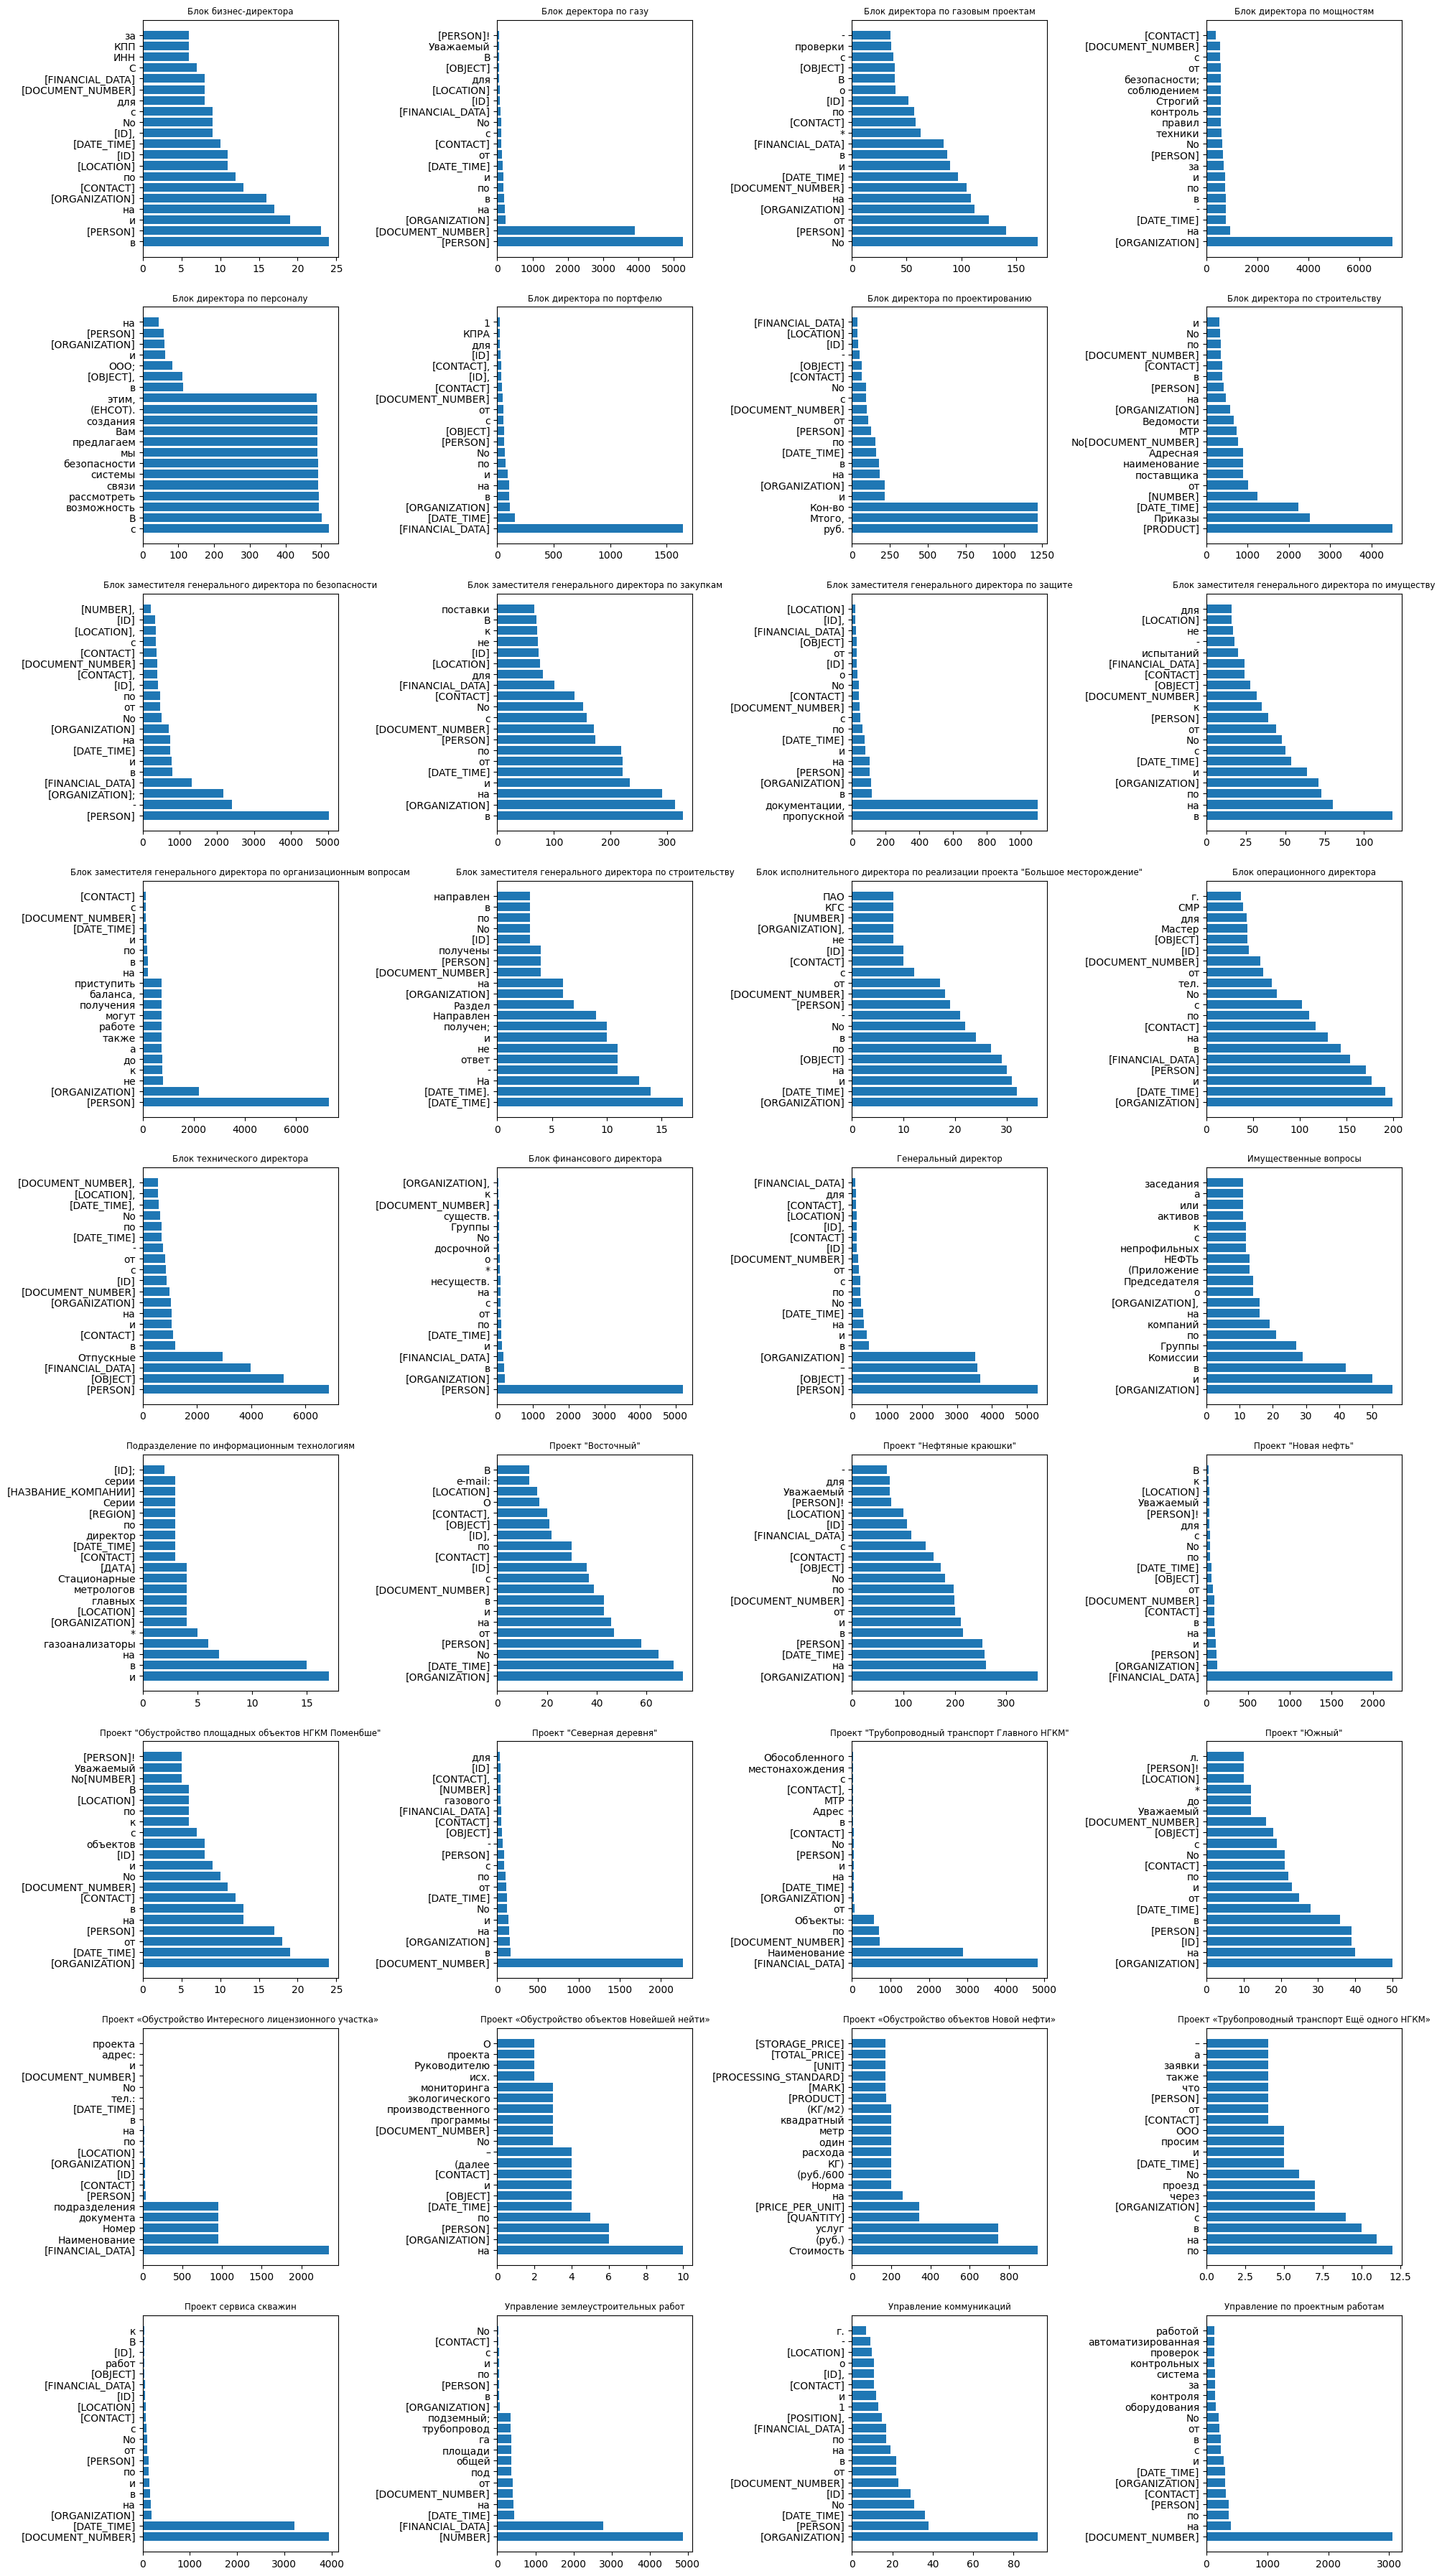

In [10]:
# Частотность слов в группах по лейблу
from collections import Counter

groups = df.groupby('label')
labels = groups.groups.keys()
labels_count = len(labels)

ncols = 4
nrows = labels_count // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

for idx, label in enumerate(labels):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col]

    group_texts = groups.get_group(label)['text']
    group_word = group_texts.apply(lambda x: x.split()).explode()
    
    word_freq = Counter(group_word)
    top_words = word_freq.most_common(20)
    
    words, counts = zip(*top_words)
    ax.barh(words, counts)
    ax.set_title(label, fontsize=8.5)
    # ax.invert_yaxis()

for idx in range(labels_count, nrows * ncols):
    row, col = idx // ncols, idx % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout(pad=2.0)
plt.show()

In [11]:
# Заглушки типа [something]
all_plugs = df['text'].str.findall(r'\[([^\]]*)\]').explode().dropna().unique().tolist()
all_plugs

['PERSON',
 'ORGANIZATION',
 'DATE_TIME',
 'DOCUMENT_NUMBER',
 'FINANCIAL_DATA',
 'CONTACT',
 'LOCATION',
 'ID',
 'DOCUMENT_TYPE',
 'ENGINE_MODEL',
 'NUMBER',
 'OBJECT',
 'COUNTRY',
 'REGION',
 'DOMAIN',
 'MONTH',
 'YEAR',
 'ZIP_CODE',
 'WEBSITE',
 'CITY',
 'PROJECT',
 'LICENSE',
 'DOCUMENT',
 'EMAIL',
 'POST_CODE',
 'QUANTITY',
 'NAME',
 'ROOM',
 'TIME',
 'INVENTORY_NUMBER',
 'ADMINISTRATION',
 'DISTRICT',
 'SIGNATURE',
 'FINANCИAL_DATA',
 'POSTCODE',
 'ROUTE',
 'FINANCИАЛЬ_DATA',
 'ROAD',
 'POSITION',
 'GROUP',
 'CONDITION',
 'SYSTEM',
 'TYPE',
 'STANDARD',
 'ACTION',
 'DATE',
 'REGIONAL_OFFICE',
 'DIMENSION',
 'PRODUCT',
 'ADDRESS',
 'EVENT',
 'OPERATION',
 'KPP',
 'CERTIFICATE',
 'WORK',
 'PERIOD',
 'OKPO',
 'OGRN',
 'INN',
 'UNIT',
 'PROGRAM',
 'STREET',
 'HOUSE',
 'QUARTER',
 'LANGUAGE',
 'CALENDAR',
 'URL',
 'FIELD',
 'TOPIC',
 'TITLE',
 'DURATION',
 'PAGE',
 'DIRECTOR',
 'ORGANIZATION_NUMBER',
 'BUILDING',
 'ISLAND',
 'POSTAL_CODE',
 'AUTONOMOUS_REGION',
 'ACTIVITY',
 'EVENT_NA

In [12]:
# частотность слов
words_count = df['text'].str.split().explode().value_counts().head(50)
words_count

text
[PERSON]               38194
[FINANCIAL_DATA]       20835
[ORGANIZATION]         18704
[DOCUMENT_NUMBER]      17931
[DATE_TIME]            10888
[OBJECT]               10368
на                      7146
[NUMBER]                6840
в                       6624
и                       6014
по                      5540
от                      5400
-                       4917
[PRODUCT]               4721
с                       4396
–                       4372
No                      4280
[CONTACT]               4102
Наименование            3970
[ID]                    2947
Отпускные               2936
Приказы                 2515
[ORGANIZATION];         2232
к                       2022
[LOCATION]              1886
В                       1860
[ID],                   1627
не                      1592
для                     1423
до                      1422
руб.                    1422
за                      1322
[CONTACT],              1313
а                       1251
[LOCATION

In [13]:
# # примеры сообщений в группах
# max_width = 400

# pd.set_option('display.max_colwidth', max_width)

# for lable in all_labels:
#   print('-' * max_width)
#   print(f'{lable}:\n')
#   print(groups.get_group(lable)['text'].head(5))
#   print('-' * max_width)

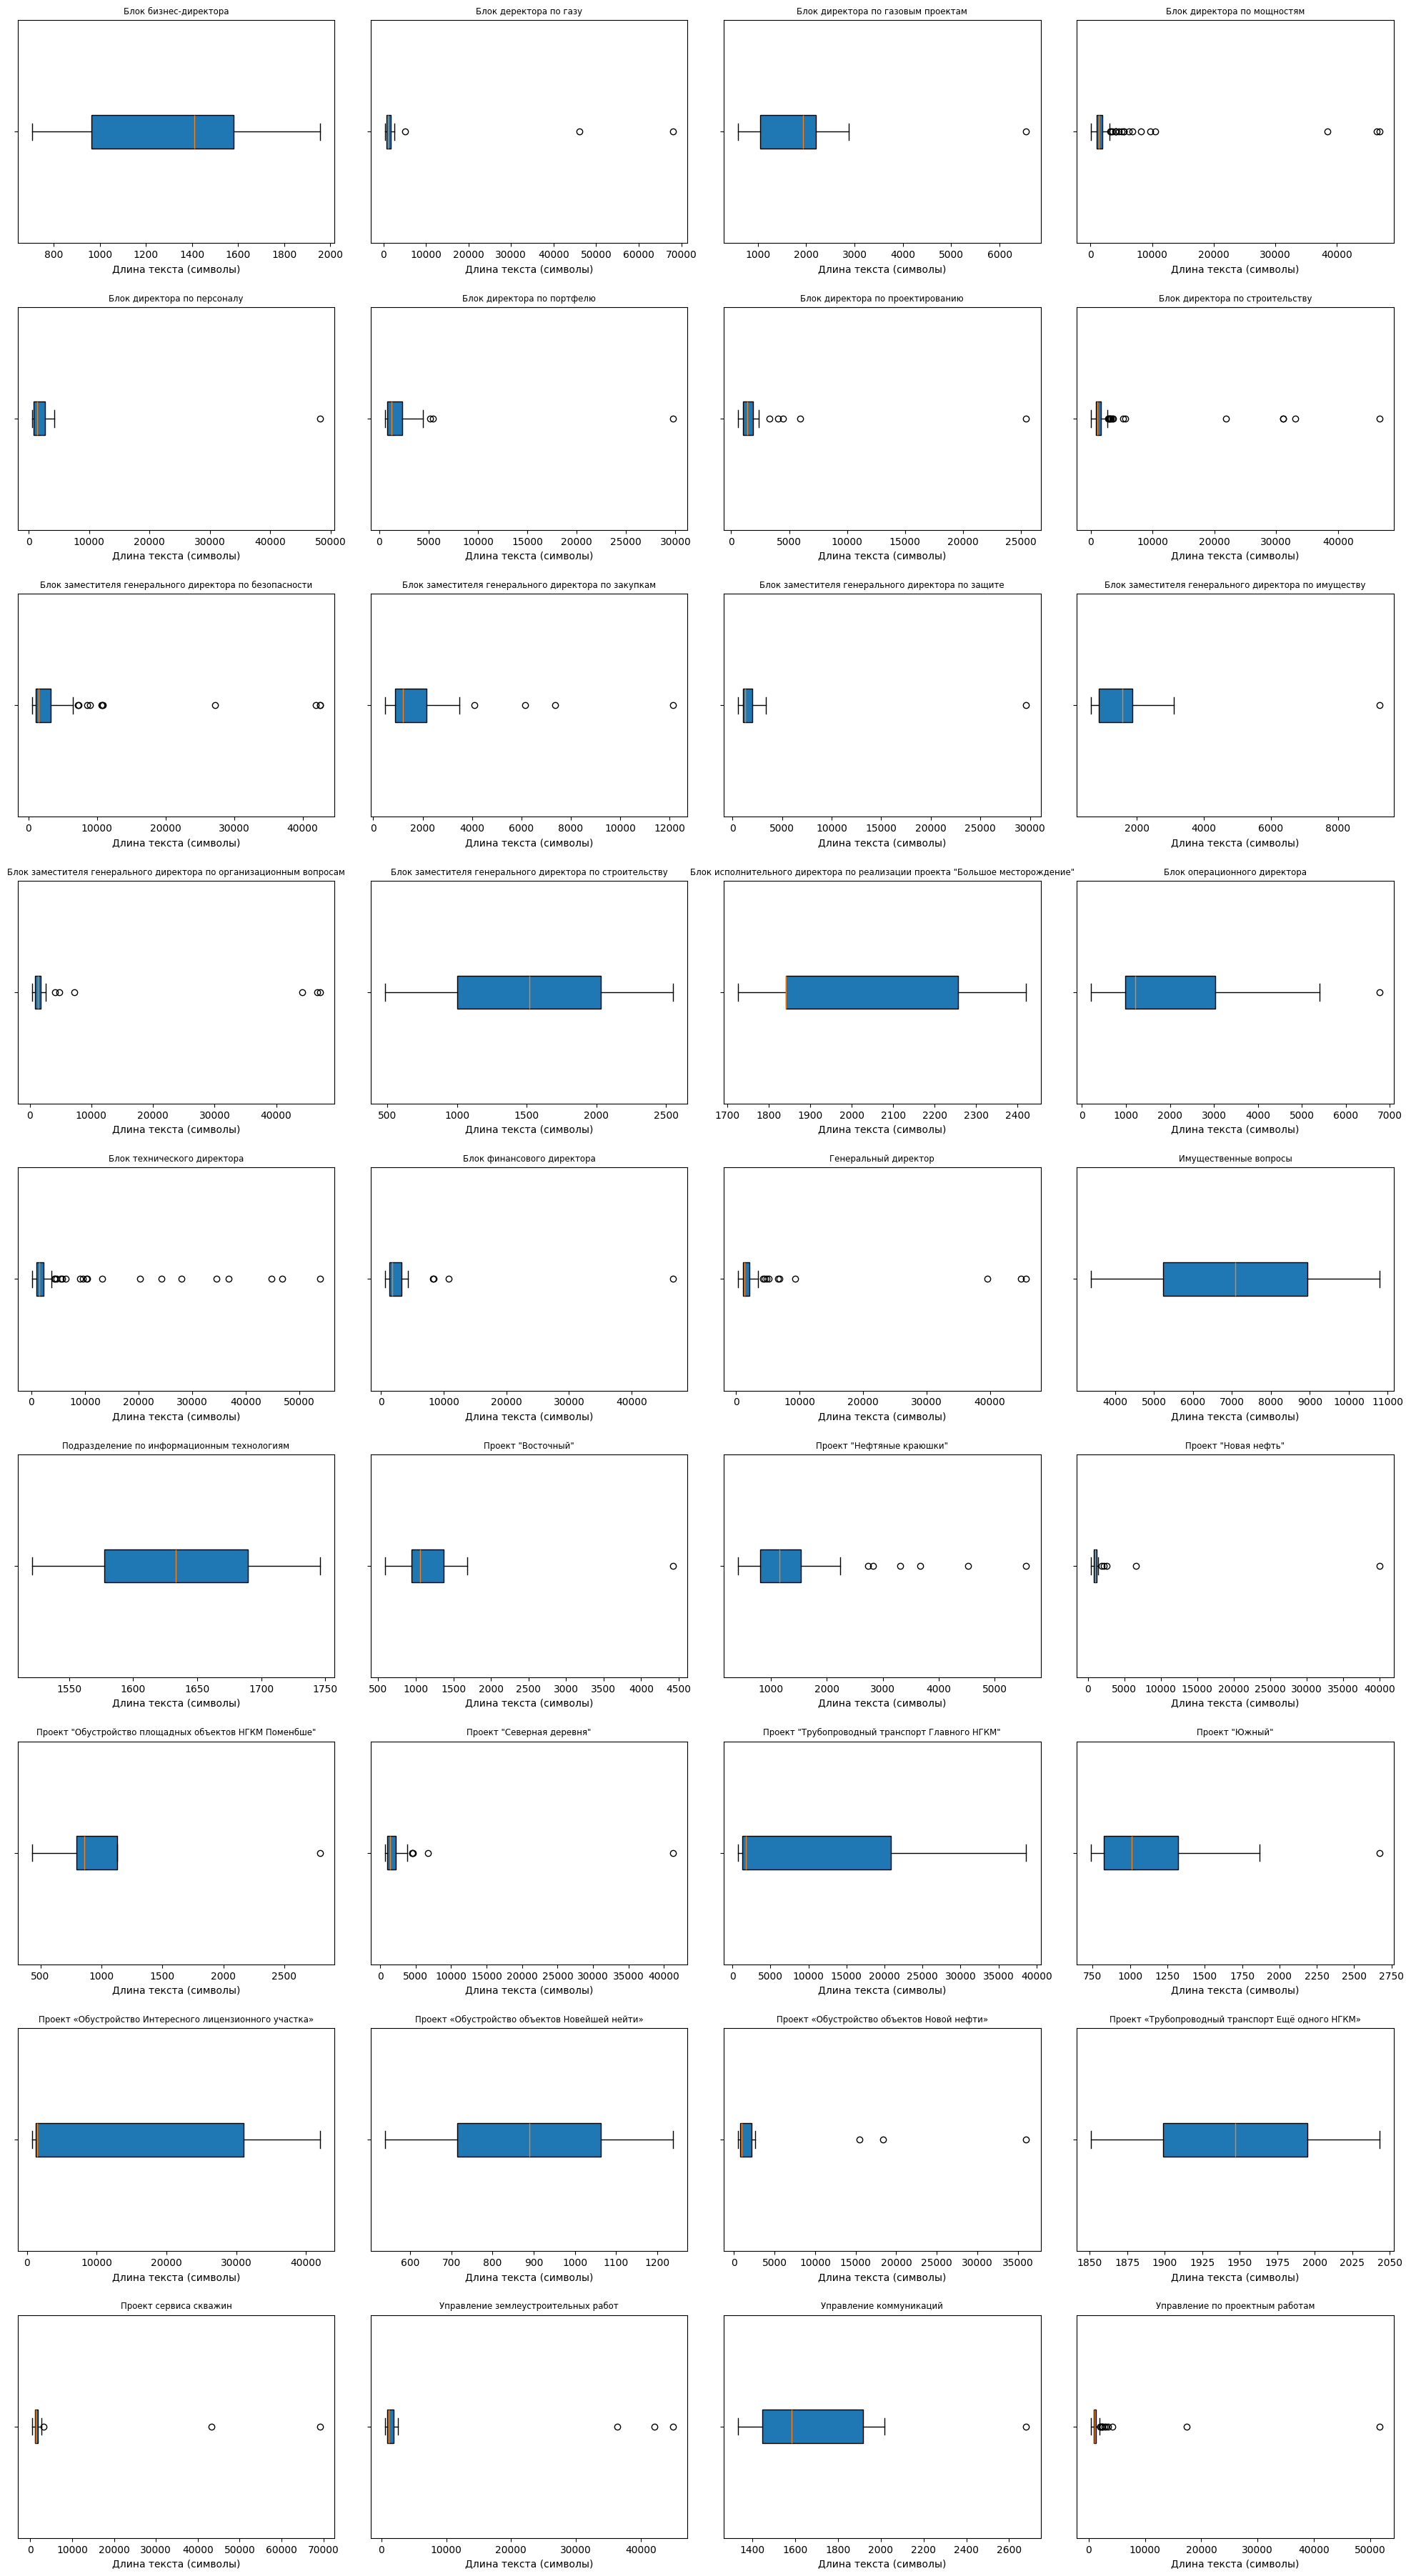

In [14]:
# Частотность слов в группах по лейблу
from collections import Counter

groups = df.groupby('label')
labels = groups.groups.keys()
labels_count = len(labels)

ncols = 4
nrows = labels_count // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

for idx, label in enumerate(labels):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col]

    group_texts = groups.get_group(label)['text']
    group_lengths = group_texts.str.len()
    
    ax.boxplot(group_lengths, vert=False, patch_artist=True)
    ax.set_yticks([1])
    ax.set_yticklabels([''])
    ax.set_title(label, fontsize=8.5)
    ax.set_xlabel('Длина текста (символы)')

for idx in range(labels_count, nrows * ncols):
    row, col = idx // ncols, idx % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout(pad=2.0)
plt.show()

## **Препроцессинг**

In [ ]:
from collections import Counter

def add_features():
    groups = df.groupby('label')
    group_texts = groups.get_group(label)['text']
    group_word = group_texts.apply(lambda x: x.split()).explode()

    text_avg_len = group_texts.str.len().mean()
    words_count = Counter(group_word)
    top2_words = words_count

def default(text):
    # text = re.sub(r'\[([^\]]*)\]', '[PLACEHOLDER]', text)
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # text = re.sub(r'\b(?:на|от|в|и|а|о|до|к)\b', '', text)
    return text

def process_default(df):
    df['text'] = df['text'].apply(default)

def clear_stopw(text):
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

def process_clear_stopw(df):
    df['text'] = df['text'].apply(clear_stopw)

def lemmatize(text):
    words = [morph.parse(word)[0].normal_form for word in text.split()]
    return ' '.join(words)

def process_lemmatize(df):
    df['text'] = df['text'].apply(lemmatize)

def augment(df, target_tiny=12, target_small=15, target_medium=25, target_large=35):
    balanced_data = []
    report = []

    for label in df['label'].unique():
        class_data = df[df['label'] == label]
        class_size = len(class_data)

        if class_size < 30:
            if class_size < 5:
                target = target_tiny
                msg_type = "ОЧЕНЬ МАЛЕНЬКИЙ"
            elif class_size < 10:
                target = target_small
                msg_type = "МАЛЕНЬКИЙ"
            else:  # 10 <= class_size < 30
                target = target_medium
                msg_type = "СРЕДНИЙ"
            if class_size < target:
                new_data = resample(class_data, replace=True, n_samples=target, random_state=42)
                report.append(f"{msg_type}: '{label}': {class_size} → {target}")
            else:
                new_data = class_data
                report.append(f"{msg_type}: '{label}': {class_size} → {class_size} (без изменений)")
        else:  # class_size >= 30
            target = min(target_large, class_size)
            if class_size > target:
                new_data = resample(class_data, replace=False, n_samples=target, random_state=42)
                report.append(f"БОЛЬШОЙ: '{label}': {class_size} → {target}")
            else:
                new_data = class_data
                report.append(f"БОЛЬШОЙ: '{label}': {class_size} → {class_size} (без изменений)")
        balanced_data.append(new_data)
    
    return pd.concat(balanced_data)

def preprocess_all(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    if not text:
        return ""

    morph = pymorphy3.MorphAnalyzer()
    stop_words = set(stopwords.words('russian'))
    
    words = []
    for word in text.split():
        if word and word not in stop_words:
            lemma = morph.parse(word)[0].normal_form
            words.append(lemma)
    return ' '.join(words)

def process(df):
    dfc = df.copy()
    dfc['text'] = dfc['text'].apply(preprocess_all)
    dfc = augment(dfc)
    return dfc

# labels_count = dfc['label'].value_counts()
# rare_labels = labels_count[labels_count < 10].index
# dfc['label'] = dfc['label'].apply(lambda x: 'Другое' if x in rare_labels else x)

#dfc = process(pd.read_json('train_hackathon_dataset.json'))
#print(dfc)
# dfc.head(7)

## **Аугментация**

In [ ]:
TOKEN_PATTERN = r'\[([^\]]*)\]'

def back_translate(text):
    # 1. Выделяем токены
    tokens = re.findall(TOKEN_PATTERN, text)
    temp_text = text
    markers = []
    for i, token in enumerate(tokens):
        marker = f"__TOKEN_{i}__"
        temp_text = temp_text.replace(token, marker, 1)
        markers.append((marker, token))
    
    # 2. Перевод ru → en → ru через Ollama
    try:
        en = ollama.chat(model="mistral:7b-instruct-v0.2-q4_0", messages=[
            {"role": "user", "content": f"Переведи на английский:\n{temp_text}"}
        ])["message"]["content"].strip()
        
        ru = ollama.chat(model="mistral:7b-instruct-v0.2-q4_0", messages=[
            {"role": "user", "content": f"Переведи на русский:\n{en}"}
        ])["message"]["content"].strip()
    except:
        print("Error occured")
        return text  # fallback
    
    # 3. Возвращаем токены
    for marker, token in markers:
        ru = ru.replace(marker, token, 1)
    return ru

In [ ]:
# Генерация нового текста на основе примеров из класса
def generate_new_text(class_name, examples, avg_len, to_generate):
    examples_str = "\n".join([f"- {ex}" for ex in examples[:5]])
    prompt = f"""
ЗАДАЧА: написать РОВНО {to_generate} НОВЫХ РАЗЛИЧНЫХ официальных писем на РУССКОМ ЯЗЫКЕ.
ПРАВИЛА:
1. КАТЕГОРИЧЕСКИ ЗАПРЕЩЕНО писать на английском языке.
2. КАТЕГОРИЧЕСКИ ЗАПРЕЩЕНО анализировать примеры или давать комментарии.
3. КОТЕГОРИЧЕСКИ ЗАПРЕЩЕНО повторять одно и то же пьсьмо дважды - каждое письмо должно быть новым.
4. Каждое письмо должно НАЧИНАТЬСЯ с номера и пробела: "1. ", "2. ", ..., "{to_generate}."
5. Больше нигде кроме заголовка не используй номер с точкой и пробелом - ЭТО НУЖНО ДЛЯ ПАРСИНГА.
6. Используй плейсхолдеры: [PERSON], [ORGANIZATION], [DATE_TIME], [DOCUMENT_NUMBER] и т.д.
7. НЕ придумывай новые типы плейсхолдеров, вместо конкретных названий/мест/имен/времени используй встречаемые плейсхолдеры.
8. НЕ выдумывай названия проектов, кроме тех, что есть в примерах.
9. Длина каждого письма — около {avg_len} символов.
10. Больше НИЧЕГО не пиши — только пронумерованные письма.
11. БОЛЬШЕ НИГДЕ не используй цифры с точкой и пробелом - ЭТО НУЖНО ДЛЯ ПАРСИНГА

Примеры писем из отдела «{class_name}»:
{examples_str}
"""
    try:
        resp = ollama.chat(
            model="mistral:7b-instruct-v0.2-q4_0",
            messages=[{"role": "user", "content": prompt}],
            options={"temperature": 0.3, "num_predict": 2000, "top_p": 0.9}
        )
        print(f"Сгенерировано для '{class_name}'")
        print(resp["message"]["content"].strip())
        print()
        return resp["message"]["content"].strip()
    except:
        print("Error occured")
        return ""

In [ ]:
def parse_generated_texts(generated_block):
    """
    Разбирает блок сгенерированных писем вида:
    1. Текст...
    2. Текст...
    и возвращает список строк.
    """
    if not generated_block:
        return []
    
    # Разделяем по шаблону "цифра + точка + пробел"
    lines = re.split(r'\n(?=\d+\.)', generated_block)
    texts = set()
    for line in lines:
        # Убираем номер в начале: "1. Текст" → "Текст"
        clean_text = re.sub(r'^\d+\.\s*', '', line.strip())
        if clean_text and len(re.findall(r'[а-яA-Z]+', clean_text)) > 10 and len(clean_text) > 20:  # фильтр мусора
            texts.add(clean_text)
    print("Parsed:", texts)
    print()
    return list(texts)

In [ ]:
import random

def augment(df, target_size=30):
    """
    Для каждого редкого класса:
    1. Генерируем N новых текстов через LLM,
    2. Применяем back-translation к ним (для разнообразия),
    3. Добавляем к датасету.
    """
    new_rows = []
    
    for label in df['label'].unique():
        class_df = df[df['label'] == label].copy()
        n_current = len(class_df)
        
        if n_current >= target_size:
            print(f"Пропуск {label}")
            continue  # пропускаем достаточно большие классы
        
        # Берём примеры из класса
        examples = class_df['text'].tolist()
        avg_len = int(class_df['text'].str.len().mean())

        to_generate = target_size - n_current
            
        # Генерируем один раз
        generated_block = generate_new_text(label, examples, avg_len, to_generate)
        parsed_texts = parse_generated_texts(generated_block)[:to_generate]
            
        # Берём столько, сколько нужно
        to_add = []
        for parsed in parsed_texts:
            if parsed:
                to_add.append(parsed)
        new_rows.extend([{"idx": "aug", "text": text, "label": label} for text in to_add])
            
        print(f"'{label}': +{len(to_add)} писем (было {n_current}, стало {n_current + len(to_add)})")
    
    # Объединяем
    if new_rows:
        df_aug = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
        return df_aug
    else:
        return df

In [ ]:
df = pd.read_json('train_hackathon_dataset.json')

df = augment(df, target_size=20)

with open("augmented.json", 'w', encoding='utf-8') as f:
    json.dump(df, f, ensure_ascii=False, indent=4)

## **TF-IDF + XGBoost Baseline**

In [ ]:
df = pd.read_json('prepared_dataset.json')
all_labels = df['label'].unique().tolist()
df['label_num'] = df['label'].map(
    dict(
        (all_labels[i], i) for i in range(len(all_labels))
        )
    )

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42
)

print('Размер обучающей выбоки:', len(train_df))
print('Размер тестовой выбоки:', len(test_df))


vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=.9
)

X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_test_tfidf = vectorizer.transform(test_df['text'])

y_train = train_df['label_num'].values
y_test = test_df['label_num'].values

In [ ]:
print("Обучение XGBoost...")

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    tree_method='hist'
)

xgb_model.fit(
    X_train_tfidf, y_train,
    verbose=False
)

In [ ]:
def metric(y_true, y_pred, labels=None):
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=labels)

    macro_f1 = f1_per_class.mean()
    variance = f1_per_class.var()
    penalty = 0.1 * np.sqrt(variance)

    return macro_f1 - penalty

y_pred = xgb_model.predict(X_test_tfidf)
score = metric(y_test, y_pred, labels=np.arange(len(all_labels)))
print(f"metric: {score:.4f}")

In [ ]:
feature_importance = xgb_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

top_indices = np.argsort(feature_importance)[-20:]
top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]

fig, ax = plt.subplots(figsize=(12, 8))

words = [f[0] for f in top_features]
importance_values = [f[1] for f in top_features]

ax.barh(range(len(words)), importance_values)
ax.set_title('Топ-20 признаков XGBoost', fontsize=12)
ax.set_xlabel('Важность', fontsize=12)
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## **BERT**

In [47]:
# === МЕТРИКА ===
def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    f1_per_class = f1_score(labels, preds, average=None, zero_division=0)
    macro_f1 = f1_per_class.mean()
    variance = f1_per_class.var()
    target = macro_f1 - 0.1 * np.sqrt(variance)
    return {"target_metric": target, "f1_macro": macro_f1, "variance": variance}

In [48]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

In [49]:
# === ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ===
def make_dataset(dfc):
    texts = dfc["text"].astype(str).tolist()
    labels_num = [label2id[l] for l in dfc["label"]]
    return Dataset.from_dict({"text": texts, "label": labels_num})

df = pd.read_json('my_prepared_dataset.json')
df = df[df["text"].notna() & df["label"].notna() & (df["text"].str.strip() != "")].copy()

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

labels = sorted(df["label"].unique())
label2id = {lbl: i for i, lbl in enumerate(labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

train_ds = make_dataset(train_df)
test_ds = make_dataset(test_df)

In [50]:
print(f"Using device: {device}")

MODEL_NAME = "ai-forever/ruBert-base"
MAX_LENGTH = 128
BATCH_SIZE = 4
EPOCHS = 3
LR = 2e-5

# === ТОКЕНИЗАЦИЯ ===
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTH)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenized_train = train_ds.map(tokenize, batched=True, remove_columns=["text"])
tokenized_test = test_ds.map(tokenize, batched=True, remove_columns=["text"])
# === === ===

# === МОДЕЛЬ И ОБУЧЕНИЕ ===
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
).to(device)

if device == "mps":
    torch.mps.empty_cache()

training_args = TrainingArguments(
    output_dir="./output",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="target_metric",
    greater_is_better=True,
    fp16=False,
    report_to="none",
    use_mps_device=(device == "mps"),
    no_cuda=(device == "cpu"),
    dataloader_pin_memory=False,
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

print("Обучение...")
trainer.train()

# === ОЦЕНКА ===
metrics = trainer.evaluate()
print(f"\nМЕТРИКА: {metrics['eval_target_metric']:.4f}")

Using device: mps


Map:   0%|          | 0/1136 [00:00<?, ? examples/s]

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обучение...


Epoch,Training Loss,Validation Loss,Target Metric,F1 Macro,Variance
1,No log,2.784298,0.026404,0.038572,0.014804
2,2.805700,2.122567,0.129017,0.155811,0.071788
3,2.805700,1.944606,0.160111,0.188556,0.080912



МЕТРИКА: 0.1601


## **My prep**

In [46]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import pymorphy3
import json

nltk.download('stopwords', quiet=True)
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

df = pd.read_json('train_hackathon_dataset.json')
all_plugs = df['text'].str.findall(r'\[([^\]]*)\]').explode().dropna().unique().tolist()
print(f"Исходно: {len(df)} записей")

def clean(text):
    if not isinstance(text, str):
        return ""

    tokens = re.findall(r'\[([^\]]*)\]', text)
    
    temp_text = re.sub(r'\[(PERSON|ORGANIZATION|DATE_TIME|CONTACT|LOCATION)\]', '', text)
    markers = []
    for i, token in enumerate(tokens):
        marker = f"__токен_{i}__"
        temp_text = temp_text.replace(f'[{token}]', marker, 1)
        markers.append((marker, token))

    cleaned_text = re.sub(r'[^а-яёА-ЯЁ\s\d_\.:;!\-\?\(\)]', ' ', temp_text)
    cleaned_text = re.sub(r'\b(тел\.?:?|Тел\.?:?|факс:?|Факс:?|e-?mail:?|E-?mail:?|email:?|Email:?|Почтовый адрес:?)\b', ' ', cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    for marker, token in markers:
        cleaned_text = cleaned_text.replace(marker, f'[{token}]')

    words = []
    for w in cleaned_text.split():
        if w.startswith('[') and w.endswith(']'):
            words.append(w)
        elif w not in stop_words and len(w) > 2:
            words.append(w)
    
    return ' '.join(words)

# Применяем предобработку
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.strip() != '']

# def is_template_text(text):
#     words = text.split()
#     if not words:
#         return True
#     # Считаем токены
#     bracket_words = [w for w in words if w.startswith('[') and w.endswith(']')]
#     bracket_ratio = len(bracket_words) / len(words)
#     # Текст из одних токенов или с очень высокой их концентрацией
#     if bracket_ratio > 0.8:
#         return True
#     # Очень короткие шаблонные тексты
#     if len(text) < 50 and bracket_ratio > 0.3:
#         return True
#     return False

final_data = df[['idx', 'text', 'label']].to_dict(orient='records')

with open('my_prepared_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(final_data, f, ensure_ascii=False, indent=2)

print(f"Подготовлено {len(final_data)} записей для отправки на сервер")

Исходно: 1421 записей
Подготовлено 1421 записей для отправки на сервер
